In [24]:
function forwardstep(x0,t0,F::Function,u,h)
    N = size(u,2) # number of cols of u
    n = length(x0)
    xs = zeros(eltype(x0),n,N+1)
    xs[:,1] = x0
    for i = 0:N-1
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1])
    end
    xs
end

forwardstep (generic function with 1 method)

In [25]:
function adjointstep(λend,t0,dFdx::Function,xs,u,h)
    N = size(u,2)
    n = length(λend)
    λs = zeros(eltype(λend),n,N)
    λs[:,N] = λend
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xs[:,i+1],u[:,i+1])'*λs[:,i+2]
    end
    λs
end

adjointstep (generic function with 1 method)

In [26]:
function G(x0,t0,u,h,F::Function,g::Function)
    xs = forwardstep(x0,t0,F,u,h)
    g(xs[:,end])
end

function dG(x0,t0,u,h,F::Function,dFdx::Function,dFdu::Function,dg::Function)
    xs = forwardstep(x0,t0,F,u,h)
    λend = dg(xs[:,end])
    λs = adjointstep(λend,t0,dFdx,xs,u,h)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:,i+1] = h*dFdu(t0+i*h,xs[:,i+1],u[:,i+1])'*λs[:,i+1]
    end
    dGval
end

dG (generic function with 1 method)

In [27]:
function proj_u(u,a,b)
    clamp.(u,a,b)
end

proj_u (generic function with 1 method)

In [28]:
function optcontrol(x0,t0,u,h,
        F::Function,dFdx::Function,dFdu::Function,g::Function,dg::Function,proj::Function;
        eps=1e-2,s0=1.0,c1=0.05,maxiter::Int=10_000,ulist=nothing,trace=0)
    Gval = G(x0,t0,u,h,F,g)
    Gvalold = Gval
    if trace > 0
        println("optcontrol: Gval = $Gval")
    end
    dGval = dG(x0,t0,u,h,F,dFdx,dFdu,dg)
    if trace > 1
        println("optcontrol: dGval = ",dGval)
    end
    firsttime = true
    iter = 0
    if ulist != nothing
        push!(ulist,u)
    end
    if trace > 0
        println("optcontrol: iteration $iter: Gval = $Gval")
        println("optcontrol: u = ",u)
    end
    println("Gvalold: ", Gvalold)
    println("Gval: ", Gval)
    while ( firsttime || (Gvalold - Gval > eps) ) && (iter < maxiter)
        Gvalold = Gval
        s = s0
        unew = proj(u-s*dGval) # projected gradient descent
        Gval = G(x0,t0,unew,h,F,g)
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-12*s0
            s = s / 2
            unew = proj(u-s*dGval)
            Gval = G(x0,t0,unew,h,F,g)
        end
        if trace > 0
            println()
            println("optcontrol: s = $s")
            println("optcontrol: Gval = $Gval, Gval-Gvalold = $(Gval-Gvalold)")
            if trace > 1
                println("optcontrol: unew = ",unew)
                println("optcontrol: dGval = ",dGval)
            end
        end
        u = unew
        firsttime = false
        dGval = dG(x0,t0,u,h,F,dFdx,dFdu,dg)
        if trace > 1
            println("optcontrol: dGval = ",dGval)
        end
        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
        if iter < 5
            println("==========================")
            println("Iteration ", iter)
            println("--------------------------")
            println("Values: ")
            println("Gvalold: ", Gvalold)
            println("Gval: ", Gval)
            println("u: ", u)
            println("dGval: ", dGval)
        end
    end
    (u,iter)
end

optcontrol (generic function with 1 method)

In [29]:
F(t,xv,u) = let x = xv[1], y = xv[2]; [u[1]; x^2] end
dFdx(t,xv,u) = let x = xv[1], y = xv[2]; [0 0 ;2x 0] end
dFdu(t,xv,u) = reshape([1.0; 0.0],2,1)

test = dFdu(0,0,0)
println("--------")
println(test)
println(typeof(test))
println("=========")
println(dFdu(0,0,0))
g(xv) = xv[2]
dg(xv) = [0.0; 1.0]

--------
[1.0; 0.0;;]
Matrix{Float64}
[1.0; 0.0;;]


dg (generic function with 1 method)

In [30]:
using LinearAlgebra
xv  = [2.1; 1.1]
dxv = 1e-3*[1.2; -0.7]
t = 0; u = [0.5]; du = 1e-3*[0.7]
dFdu(t,xv,u)

2×1 Matrix{Float64}:
 1.0
 0.0

In [31]:
using LinearAlgebra
xv  = [2.1; 1.1]
dxv = 1e-3*[1.2; -0.7]
t = 0; u = [0.5]; du = 1e-3*[0.7]
@show (F(t,xv+dxv,u)-F(t,xv-dxv,u)-2dFdx(t,xv,u)*dxv)/norm(dxv)
@show (F(t,xv,u+du)-F(t,xv,u-du)-2*dFdu(t,xv,u)*du)/norm(du)
@show (g(xv+dxv)-g(xv-dxv)-2*dot(dg(xv),dxv))/norm(dxv)

((F(t, xv + dxv, u) - F(t, xv - dxv, u)) - (2 * dFdx(t, xv, u)) * dxv) / norm(dxv) = [0.0, -1.053887001334176e-12]
((F(t, xv, u + du) - F(t, xv, u - du)) - 2 * dFdu(t, xv, u) * du) / norm(du) = [1.7657006809049645e-14, 0.0]
((g(xv + dxv) - g(xv - dxv)) - 2 * dot(dg(xv), dxv)) / norm(dxv) = 1.1097654886679491e-13


1.1097654886679491e-13

In [32]:
N = 20
h = 0.1
u = -ones(1,N)
println(typeof(u))
println(u)
xv0 = [1.0; 0.0]
xs = forwardstep(xv0,0.0,F,u,h)

Matrix{Float64}
[-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0]


2×21 Matrix{Float64}:
 1.0  0.9  0.8    0.7    0.6    0.5   0.4    …  -0.7    -0.8    -0.9    -1.0
 0.0  0.1  0.181  0.245  0.294  0.33  0.355      0.476   0.525   0.589   0.67

In [33]:
λend = dg(xs[:,end])


2-element Vector{Float64}:
 0.0
 1.0

In [34]:
λs = adjointstep(λend,0.0,dFdx,xs,u,h)


2×20 Matrix{Float64}:
 0.38  0.18  5.55112e-16  -0.16  -0.3  …  -0.52  -0.42  -0.3  -0.16  0.0
 1.0   1.0   1.0           1.0    1.0      1.0    1.0    1.0   1.0   1.0

In [35]:
dFdx(0,xs[:,end-1],u[:,end])'*λend

2-element Vector{Float64}:
 -1.7999999999999996
  0.0

In [36]:
G(xv0,0.0,u,h,F,g)


0.6699999999999999

In [37]:
dG(xv0,0.0,u,h,F,dFdx,dFdu,dg)

1×20 Matrix{Float64}:
 0.038  0.018  5.55112e-17  -0.016  …  -0.052  -0.042  -0.03  -0.016  0.0

In [38]:
du = 1e-3*rand(1,20)
(G(xv0,0.0,u+du,h,F,g)-G(xv0,0.0,u-du,h,F,g)-2*dot(dG(xv0,0.0,u,h,F,dFdx,dFdu,dg),du))/norm(h*du,1)

-0.412225559125876

In [39]:
N = 80
h = 0.025
u = -ones(1,N)
xv0 = [1.0; 0.0]

2-element Vector{Float64}:
 1.0
 0.0

In [40]:
du = 1e-3*rand(1,N)
(G(xv0,0.0,u+du,h,F,g)-G(xv0,0.0,u-du,h,F,g)-2*dot(dG(xv0,0.0,u,h,F,dFdx,dFdu,dg),du))/norm(h*du,1)

-0.10595909807862172

In [41]:
ulist = []
u = zeros(1,20)
h = 0.1
uopt,iterns = optcontrol(xv0,0.0,u,h,F,dFdx,dFdu,g,dg,u->proj_u(u,-1.0,1.0),eps=1e-4,maxiter=40,ulist=ulist,trace=0)

Gvalold: 2.0000000000000004
Gval: 2.0000000000000004
Iteration 1
--------------------------
Values: 
Gvalold: 2.0000000000000004
Gval: 1.1623735999999996
u: [-0.3800000000000001 -0.3600000000000001 -0.3400000000000001 -0.32000000000000006 -0.30000000000000004 -0.28 -0.26 -0.24 -0.21999999999999997 -0.19999999999999998 -0.18 -0.16 -0.13999999999999999 -0.12 -0.1 -0.08000000000000002 -0.06000000000000001 -0.04000000000000001 -0.020000000000000004 0.0]
dGval: [0.28879999999999995 0.26879999999999993 0.24955999999999992 0.2310399999999999 0.21319999999999995 0.19599999999999992 0.17939999999999992 0.16335999999999995 0.14783999999999994 0.13279999999999995 0.11819999999999996 0.10399999999999997 0.09015999999999996 0.07663999999999997 0.06339999999999997 0.05039999999999998 0.03759999999999998 0.02495999999999999 0.012439999999999994 0.0]
Iteration 2
--------------------------
Values: 
Gvalold: 1.1623735999999996
Gval: 0.7476206523023996
u: [-0.6688000000000001 -0.6288 -0.58956 -0.55104 -0

([-1.0 -1.0 … -0.0015627896305092015 0.0], 38)

In [42]:
uopt


1×20 Matrix{Float64}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.00680896  -0.00156279  0.0

In [43]:
xsopt = forwardstep(xv0,0.0,F,uopt,h)


2×21 Matrix{Float64}:
 1.0  0.9  0.8    0.7    0.6    0.5   …  -0.0407103  -0.0408666  -0.0408666
 0.0  0.1  0.181  0.245  0.294  0.33      0.386606    0.386772    0.386939

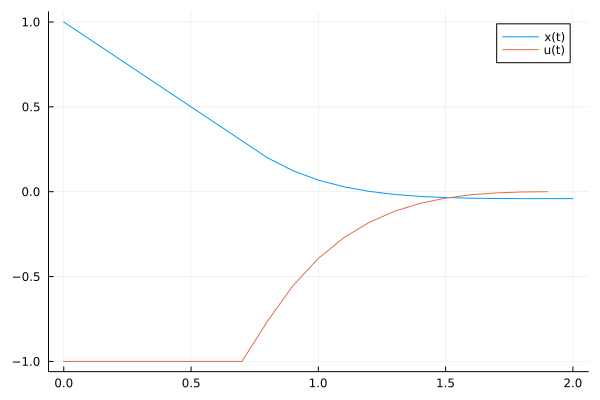

In [44]:
using Plots
plot(h*(0:20),xsopt[1,:],label="x(t)")
plot!(h*(0:19),uopt[1,:],label="u(t)")